In [1]:
"""
This code implement the Actor Critic Alogrithms
"""
import numpy as np
import pandas as pd
import tensorflow as tf
import gym
from collections import namedtuple
import matplotlib
from matplotlib import pyplot as plt

In [2]:
RENDER_ENV = False
LEARNING_RATE_ACTOR = 0.001
LEARNING_RATE_CRITIC = 0.01
GAMMA = 0.9
OUTPUT_GRAPH = False
ENVNAME = "CartPole-v0"
NUM_EPISODES = 500

In [3]:
class Actor(object):
    def __init__(self, sess, n_features, n_actions, lr=0.001):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.a = tf.placeholder(tf.int32, None, "act")
        self.td_error = tf.placeholder(tf.float32, None, "td_error")  # TD_error

        with tf.variable_scope('Actor'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=20,    # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),    # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.acts_prob = tf.layers.dense(
                inputs=l1,
                units=n_actions,    # output units
                activation=tf.nn.softmax,   # get action probabilities
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='acts_prob'
            )

        with tf.variable_scope('exp_v'):
            log_prob = tf.log(self.acts_prob[0, self.a])
            self.exp_v = tf.reduce_mean(log_prob * self.td_error)  # advantage (TD_error) guided loss

        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)  # minimize(-exp_v) = maximize(exp_v)

    def learn(self, s, a, td):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.td_error: td}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def choose_action(self, s):
        s = s[np.newaxis, :]
        probs = self.sess.run(self.acts_prob, {self.s: s})   # get probabilities for all actions
        return np.random.choice(np.arange(probs.shape[1]), p=probs.ravel())   # return a int


class Critic(object):
    def __init__(self, sess, n_features, lr=0.01):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.v_ = tf.placeholder(tf.float32, [1, 1], "v_next")
        self.r = tf.placeholder(tf.float32, None, 'r')

        with tf.variable_scope('Critic'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=20,  # number of hidden units
                activation=tf.nn.relu,  # None
                # have to be linear to make sure the convergence of actor.
                # But linear approximator seems hardly learns the correct Q.
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.v = tf.layers.dense(
                inputs=l1,
                units=1,  # output units
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='V'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.r + GAMMA * self.v_ - self.v
            self.loss = tf.square(self.td_error)    # TD_error = (r+gamma*V_next) - V_eval
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = self.sess.run(self.v, {self.s: s_})
        td_error, _ = self.sess.run([self.td_error, self.train_op],
                                          {self.s: s, self.v_: v_, self.r: r})
        return td_error

In [4]:
def plot_episode_stats1(rec, xlabel, ylabel,title):
    fig = plt.figure(figsize=(20, 10), facecolor = "white")
    ax = fig.add_subplot(111)
    ax.plot(rec) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig

def plot_episode_stats2(stats):
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(20, 10))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    return fig3

def Plot_the_result(rec):
    # Plot episode length over time
    episode_lengths = rec.episode_lengths
    fig = plot_episode_stats1(episode_lengths, 
                       xlabel = "Episode",
                       ylabel = "Episode Length",
                       title = "Episode length over Time"
            )
    fig.show()
    fig.savefig("./log/AC_tf_CartPole_EpisodeLength.jpg")

    # Plot Episode reward over time
    smoohing_window = 10
    reward_smooths = pd.Series(rec.episode_rewards).rolling(smoohing_window,\
                    min_periods = smoohing_window).mean()
    fig = plot_episode_stats1(reward_smooths, 
                       xlabel = "Episode",
                       ylabel = "Episode Reward",
                       title = "Episode reward over time"
            )
    fig.show()
    fig.savefig("./log/AC_tf_CartPole_EpisodeReward.jpg")
    
    # Plot Episode per time step
    fig = plot_episode_stats2(rec)
    fig.show()
    fig.savefig("./log/AC_tf_CartPole_EpisodePerTimeStep.jpg")

In [5]:
def update(actor, critic, env, num_episodes):
    # Track the statistics of the result
    record = namedtuple("Record", ["episode_lengths","episode_rewards"])
    
    rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        if 0 == (i_episode +1) % 1:
            print("This the episode {}/{}".format(i_episode, num_episodes), end = "\r")
        observation = env.reset()
        step =0
        reward_cum = 0
        done = False
        while True:
            #env.render()
            if RENDER_ENV:
                env.render()
            action = actor.choose_action(observation)
            observation_next, reward, done, info = env.step(action)
            if done:
                reward = -20
            # update the record
            step += 1
            rec.episode_lengths[i_episode] = step 
            rec.episode_rewards[i_episode] += reward
            td_error = critic.learn(observation, reward, observation_next)
            actor.learn(observation, action, td_error)
            if done:
                if 0 == (i_episode +1) % 5:
                    print("The reward at episode {} is {}.".format(i_episode, 
                                            rec.episode_rewards[i_episode]))
                break
            observation = observation_next
    print("Finished")
    env.close()
    return rec

Instructions for updating:
Use keras.layers.dense instead.
The reward at episode 4 is -2.0.
The reward at episode 9 is -6.0.
The reward at episode 14 is 12.0.
The reward at episode 19 is -9.0.
The reward at episode 24 is -6.0.
The reward at episode 29 is -2.0.
The reward at episode 34 is 4.0.
The reward at episode 39 is 0.0.
The reward at episode 44 is 15.0.
The reward at episode 49 is -4.0.
The reward at episode 54 is 14.0.
The reward at episode 59 is 63.0.
The reward at episode 64 is 20.0.
The reward at episode 69 is -5.0.
The reward at episode 74 is -8.0.
The reward at episode 79 is 35.0.
The reward at episode 84 is 6.0.
The reward at episode 89 is 13.0.
The reward at episode 94 is 9.0.
The reward at episode 99 is 40.0.
The reward at episode 104 is 47.0.
The reward at episode 109 is 59.0.
The reward at episode 114 is 29.0.
The reward at episode 119 is 2.0.
The reward at episode 124 is 14.0.
The reward at episode 129 is 7.0.
The reward at episode 134 is 25.0.
The reward at episode 13

/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


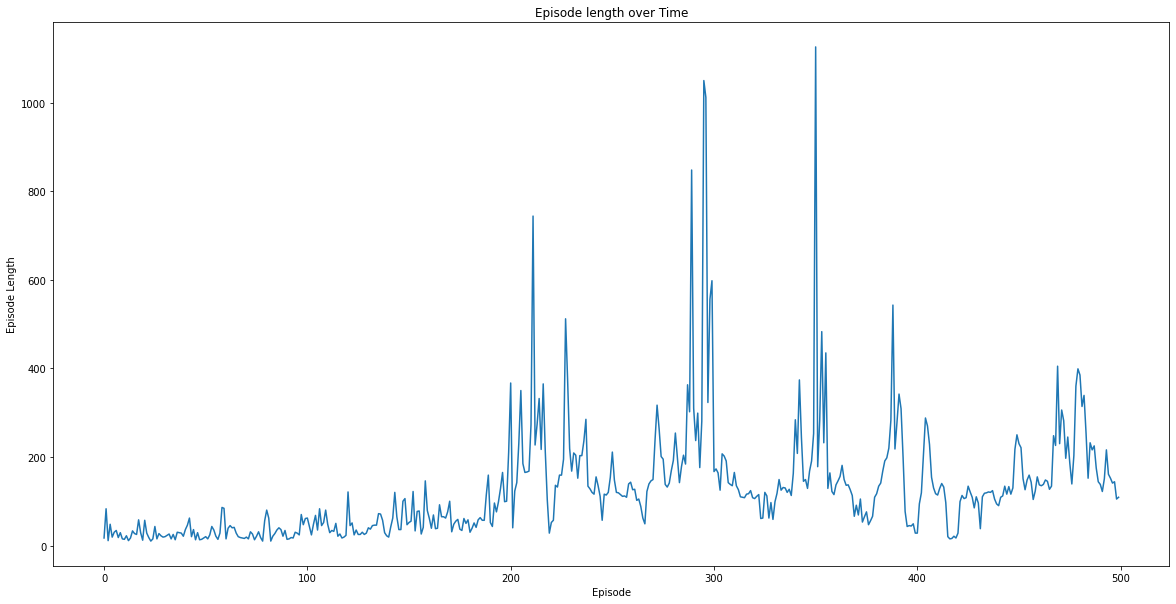

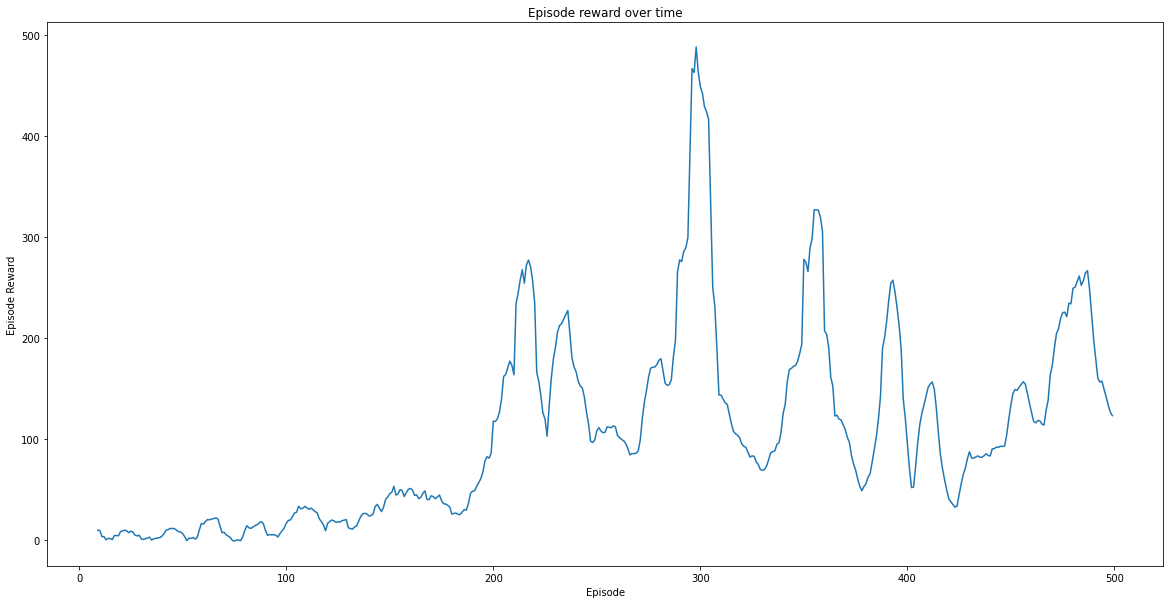

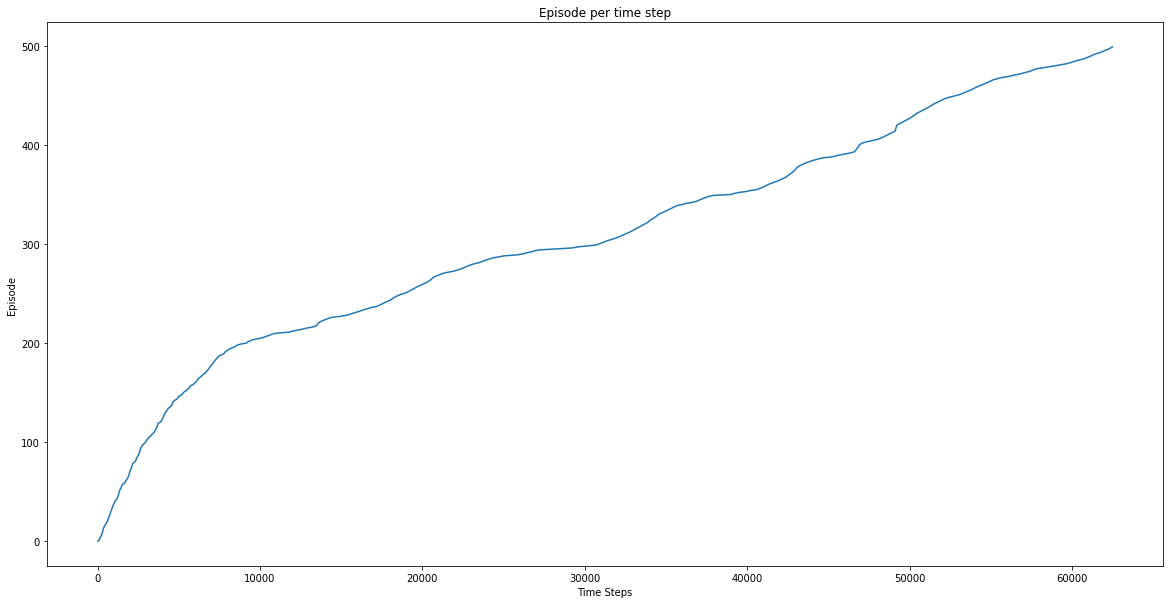

In [6]:
if __name__ == "__main__":
    env = gym.envs.make(ENVNAME)
    env = env.unwrapped
    env.seed(1)
    n_action = env.action_space.n
    n_feature = env.observation_space.shape[0]
    sess = tf.Session()
    actor = Actor(sess, n_features=n_feature, n_actions=n_action, lr=LEARNING_RATE_ACTOR)

    critic = Critic(sess, n_features=n_feature, lr=LEARNING_RATE_CRITIC) 
    sess.run(tf.global_variables_initializer())
    if OUTPUT_GRAPH:
        tf.summary.FileWriter("log/",sess.graph)
        
    rec = update(actor, critic, env, num_episodes=NUM_EPISODES)
    #Plot the result
    Plot_the_result(rec)